Script to investigate the members found at a FPR@$\beta$ of single instance of a attack $a$ v.s. the members found at the same FPR@$\beta$ of multi instance of the same attack $a$. (Archived, not used in our paper)

In [1]:
import os
import numpy as np
from typing import List, Tuple, Dict
import itertools
from copy import deepcopy
import sys
from pandas import DataFrame
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append("../../../")
sys.path.append("../../")
sys.path.append("../")
from miae.eval_methods.experiment import ExperimentSet, TargetDataset
from miae.eval_methods.prediction import Predictions, HardPreds, plot_roc_hard_preds, get_fpr_tpr_hard_label

sns.set_context("paper")
# set fontsize
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=7)
plt.rc('font', size=7)       
plt.rc('axes', titlesize=8)    
plt.rc('axes', labelsize=8)


plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

mia_name_mapping = {"losstraj": "losstraj", "shokri": "Class-NN", "yeom": "LOSS", "lira": "LiRA", "aug": "aug", "calibration": "calibrated-loss", "reference": "reference"}
mia_color_mapping = {"losstraj": '#1f77b4', "shokri": '#ff7f0e', "yeom": '#2ca02c', "lira": '#d62728', "aug": '#9467bd', "calibration": '#8c564b', "reference": '#e377c2'}


In [2]:
# parameters:
attack = "reference" # could be "reference", "lira", "shokri", "calibration"
dataset = "cifar10" # could be "cifar10", "cifar100", "cinic10"
base_fpr = 0.01 # the base fpr for each instance
seeds = [0, 1, 2, 3, 4, 5]
model = "resnet56"
ensemble_method = "intersection"
datapath = "data/miae_experiment_aug_more_target_data"
save_path = f'{datapath}/multi_instance_vs_single_instance'
if not os.path.exists(save_path):
    os.makedirs(save_path)

1. Load the experiment set and dataset

In [7]:
target_dataset = TargetDataset.from_dir(dataset, f"{datapath}/target/{dataset}")
experiment = ExperimentSet.from_dir(target_dataset, [attack], datapath, seeds, model)
print("Loaded successfully.")

Loaded successfully.


2. Load the the predictions of `seeds`, adjust them to `base_fpr`, and ensemble them with `ensemble_method`.

In [ ]:
%pip install nbimporter

Note: you may need to restart the kernel to use updated packages.


In [ ]:

import nbimporter
from max_ensemble_low_fpr import apply_operation

# Store Predictions for each seed
seed_predictions = []

# Iterate through each seed and load the predictions for the specified attack
for seed in seeds:
    # Retrieve predictions for the specified attack and seed
    predictions = experiment.retrieve_preds(attack, seed)
    
    # Adjust predictions to the specified  False Positive Rate (base_fpr) 
    # Meaning that each single-seed prediction should achieve approximately this FPR before ensembling.
    adjusted_predictions = Predictions(predictions.adjust_fpr(base_fpr), predictions.ground_truth_arr, predictions.name)
    
    # Append the adjusted predictions to the list
    seed_predictions.append(adjusted_predictions)

# Use apply_operation to ensemble the adjusted predictions across seeds
ensemble_predictions = apply_operation(seed_predictions, operation=ensemble_method)


print(f"Ensembled predictions using method '{ensemble_method}' at base FPR {base_fpr}.")


Ensembled predictions using method 'intersection' at base FPR 0.01.


3. Calculate the FPR after ensemble (this FPR would be the $\beta$ mentioned above), and pick the same attack with seed 0 (single-instance), to adjust the FPR to the same value $\beta$.

In [14]:
# Calculate the FPR of the ensemble predictions
ensemble_fpr = ensemble_predictions.compute_fpr()
print(f"FPR (β) of ensemble predictions: {ensemble_fpr}")


# Predictions for the same attack with seed 0 (single-instance)
single_instance_predictions = experiment.retrieve_preds(attack, 0)

# Adjust the single-instance predictions to match the ensemble FPR (β)
adjusted_single_instance_predictions = Predictions(
    single_instance_predictions.adjust_fpr(ensemble_fpr),
    single_instance_predictions.ground_truth_arr,
    f"{attack}_single_instance_adjusted"
)

print(f"Single-instance adjusted to ensemble FPR (β) at {ensemble_fpr}.")




FPR (β) of ensemble predictions: 0.0003333333333333333
Single-instance adjusted to ensemble FPR (β) at 0.0003333333333333333.


4. Plot Venn Diagram to compare the members found at the same FPR@$\beta$ of single instance of a attack $a$ v.s. the members found at the same FPR@$\beta$ of multi instance of the same attack $a$.

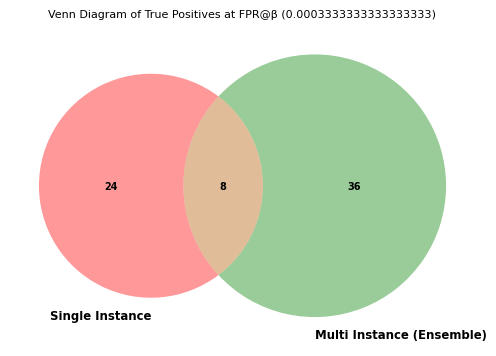

In [16]:
from matplotlib_venn import venn2

# Get true positive for both single-instance and multi-instance predictions
ensemble_tp_indices = set(ensemble_predictions.get_tp())
single_instance_tp_indices = set(adjusted_single_instance_predictions.get_tp())

# Calculate unique and overlapping indices
unique_to_ensemble = len(ensemble_tp_indices - single_instance_tp_indices)
unique_to_single = len(single_instance_tp_indices - ensemble_tp_indices)
intersection = len(ensemble_tp_indices & single_instance_tp_indices)

# Plot Venn Diagram
plt.figure(figsize=(6, 6))
venn2(
    subsets=(unique_to_single, unique_to_ensemble, intersection),
    set_labels=('Single Instance', 'Multi Instance (Ensemble)')
)
plt.title(f"Venn Diagram of True Positives at FPR@β ({ensemble_fpr})")
plt.show()



After using intersection (stability), the FPR decrease, drop to nearly zero. At this low FPR:

1.  Multi-instance ensemble has overall identified more true positives compared to the single-instance.
2.  Low overlap indicates that each instance captures a different set of members?

